# Risk Factors for Cardiovascular Heart Disease

Cilj ovog projekta je rešavanje **problema binarne klasifikacije**, gde se na osnovu demografskih, bioloških i životnih faktora predviđa prisustvo kardiovaskularne bolesti (`cardio`).

### Pregled skupa podataka
Skup podataka sadrži informacije o više od 70.000 ispitanika i obuhvata podatke o starosti, polu, telesnim merama, krvnom pritisku, nivou holesterola i glukoze, kao i navikama poput pušenja, konzumacije alkohola i fizičke aktivnosti.

### Važne napomene
- Atribut `age` je izražen **u danima**, a ne u godinama, što zahteva konverziju radi lakše interpretacije.
- Vrednosti krvnog pritiska (`ap_hi`, `ap_lo`) mogu sadržati **nelogične ili ekstremne vrednosti**, koje će biti razmotrene tokom obrade podataka.
- Atributi `cholesterol` i `gluc` predstavljaju **ordinalne kategorije**, a ne kontinualne vrednosti.
- Ciljna promenljiva `cardio` je binarna:
  - `0` – nema kardiovaskularne bolesti  
  - `1` – prisutna kardiovaskularna bolest


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
df = pd.read_csv("heart_data.csv")

df.head()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        70000 non-null  int64  
 1   id           70000 non-null  int64  
 2   age          70000 non-null  int64  
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  int64  
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.5 MB


In [7]:
df.describe()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,20207.403759,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.750000,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,34999.500000,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,52499.250000,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,69999.000000,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.isnull().sum()

index          0
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

**U datasetu nema praznih vrednosti, što nam olakšava preprocesiranje.**

In [9]:
df["cardio"].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

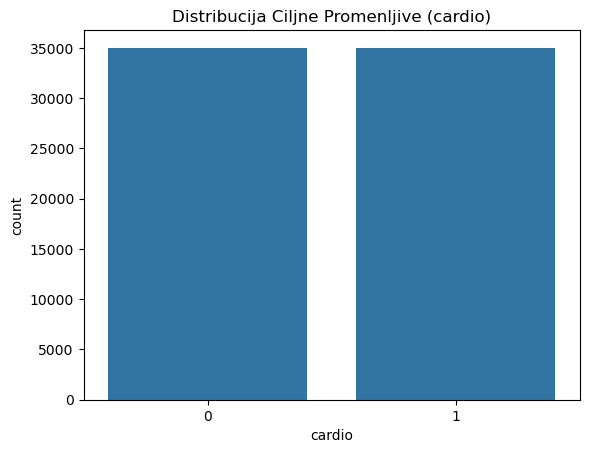

In [11]:
sns.countplot(x="cardio", data=df)
plt.title("Distribucija Ciljne Promenljive (cardio)")
plt.show()

Ovde gledamo:

da li su klase balansirane
da li će trebati class weighting kasnije

**Vidimo da imamo skoro podjednako rasprostranjene vrednosti 0 i 1 koje označavaju da li osobe imaju ili nemaju kartiovaskularne bolesti.**

### Konverzija godina

Kolona `age` je predstavljena u danima. Za bolju analizu i razumljivost konvertovaćemo ih u godine.


In [12]:
df["age_years"] = df["age"] / 365.25
df.drop(columns=["age"], inplace=True)

df[["age_years"]].describe()

,age_years
count,70000.000000
mean,53.302850
std,6.754967
min,29.563313
25%,48.361396
50%,53.943874
75%,58.390144
max,64.922656
